#Efficient SAM Example

This script provides example for how to get visualization result from EfficientSAM using weight file, part of the code is borrow from MobileSAM project, many thanks!

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Setup

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.transforms import ToTensor
from PIL import Image
import io

#Box and Point prompt

In [4]:
def run_ours_box_or_points(img_path, pts_sampled, pts_labels, model):
    image_np = np.array(Image.open(img_path))
    img_tensor = ToTensor()(image_np)
    pts_sampled = torch.reshape(torch.tensor(pts_sampled), [1, 1, -1, 2])
    pts_labels = torch.reshape(torch.tensor(pts_labels), [1, 1, -1])
    predicted_logits, predicted_iou = model(
        img_tensor[None, ...],
        pts_sampled,
        pts_labels,
    )

    sorted_ids = torch.argsort(predicted_iou, dim=-1, descending=True)
    predicted_iou = torch.take_along_dim(predicted_iou, sorted_ids, dim=2)
    max_iou_value = torch.max(predicted_iou).item()

    #print("Predicted IOU:", max_iou_value)
    predicted_logits = torch.take_along_dim(
        predicted_logits, sorted_ids[..., None, None], dim=2
    )

    return (
        torch.ge(predicted_logits[0, 0, 0, :, :], 0).cpu().detach().numpy(),
        max_iou_value
    )#return torch.ge(predicted_logits[0, 0, 0, :, :], 0).cpu().detach().numpy()

#Visualization Related

In [5]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.8])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="yellow", facecolor=(0, 0, 0, 0), lw=5)
    )

def show_anns_ours(mask, ax):
    ax.set_autoscale_on(False)
    img = np.ones((mask.shape[0], mask.shape[1], 4))
    img[:, :, 3] = 0
    color_mask = [0, 1, 0, 0.7]
    img[np.logical_not(mask)] = color_mask
    ax.imshow(img)


#Create the model and load the weights from the checkpoint.

In [6]:
!git clone https://github.com/yformer/EfficientSAM.git
import os
os.chdir("EfficientSAM")

fatal: destination path 'EfficientSAM' already exists and is not an empty directory.


In [7]:
from efficient_sam.build_efficient_sam import build_efficient_sam_vitt, build_efficient_sam_vits
#from squeeze_sam.build_squeeze_sam import build_squeeze_sam
import zipfile

efficient_sam_vitt_model = build_efficient_sam_vitt()
efficient_sam_vitt_model.eval()

# Since EfficientSAM-S checkpoint file is >100MB, we store the zip file.
with zipfile.ZipFile("weights/efficient_sam_vits.pt.zip", 'r') as zip_ref:
    zip_ref.extractall("weights")
efficient_sam_vits_model = build_efficient_sam_vits()
efficient_sam_vits_model.eval()

#squeeze_sam_model = build_squeeze_sam()
#squeeze_sam_model.eval()


EfficientSam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (proj): Linear(in_features=384, out_features=384, bias=True)
        )
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(384, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    

## Point segmentation

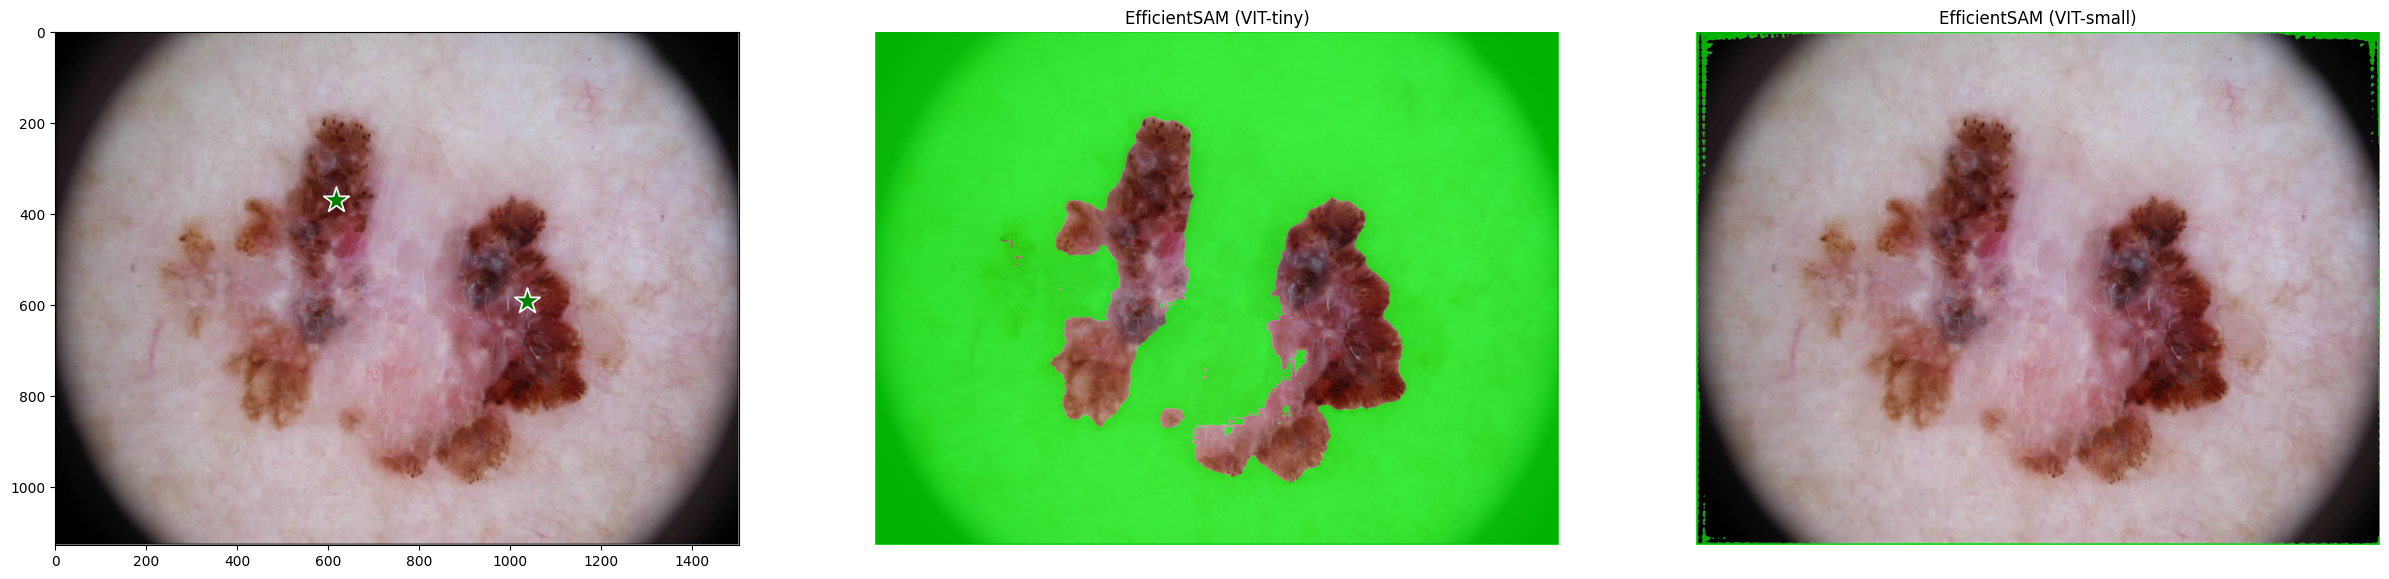

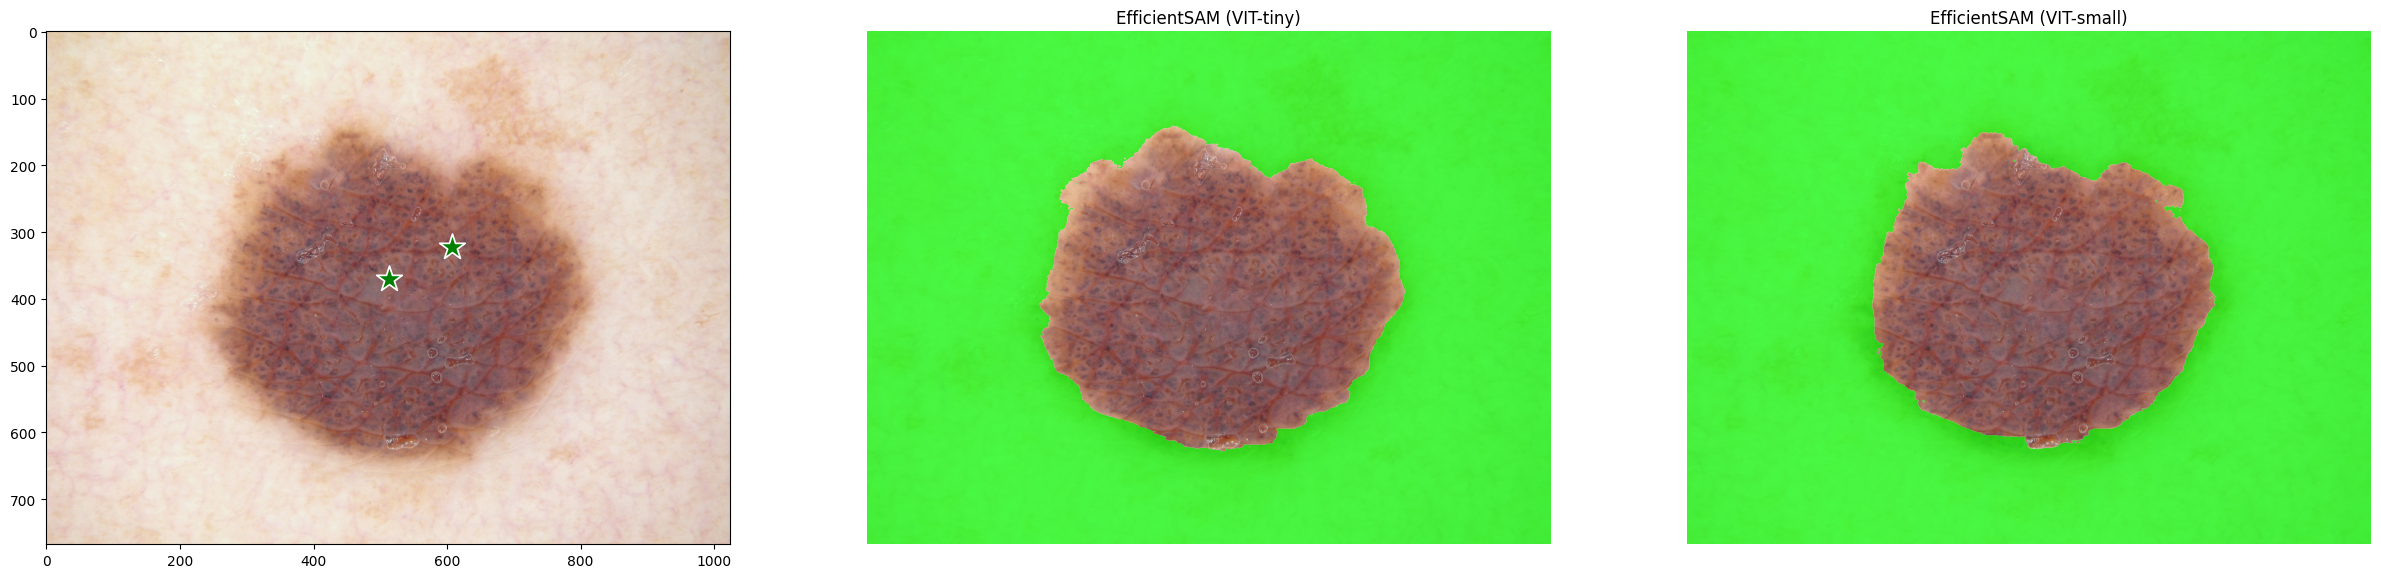

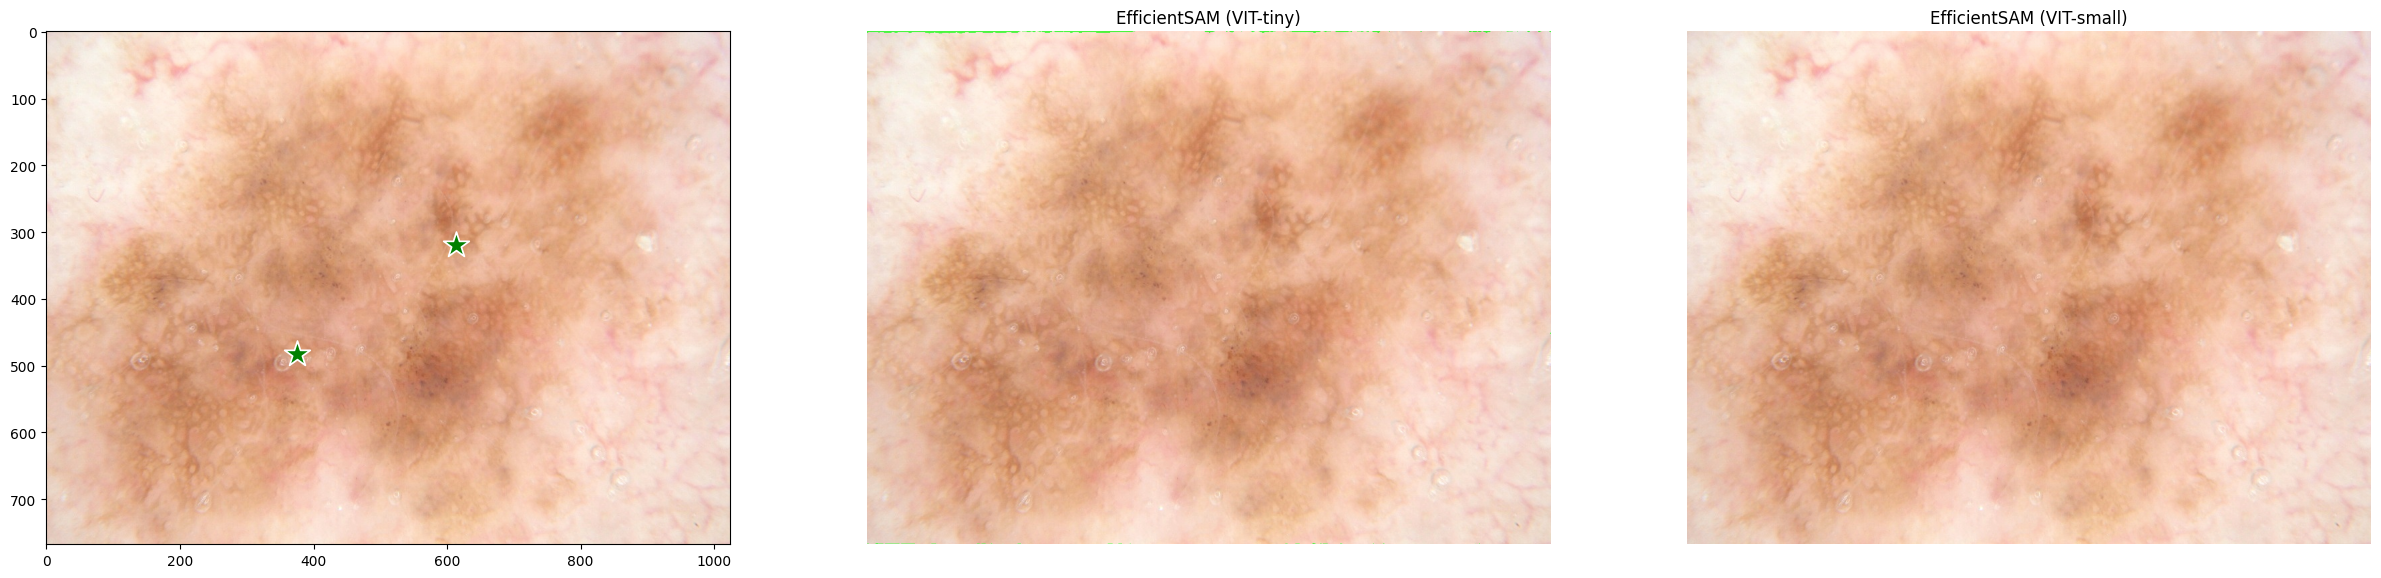

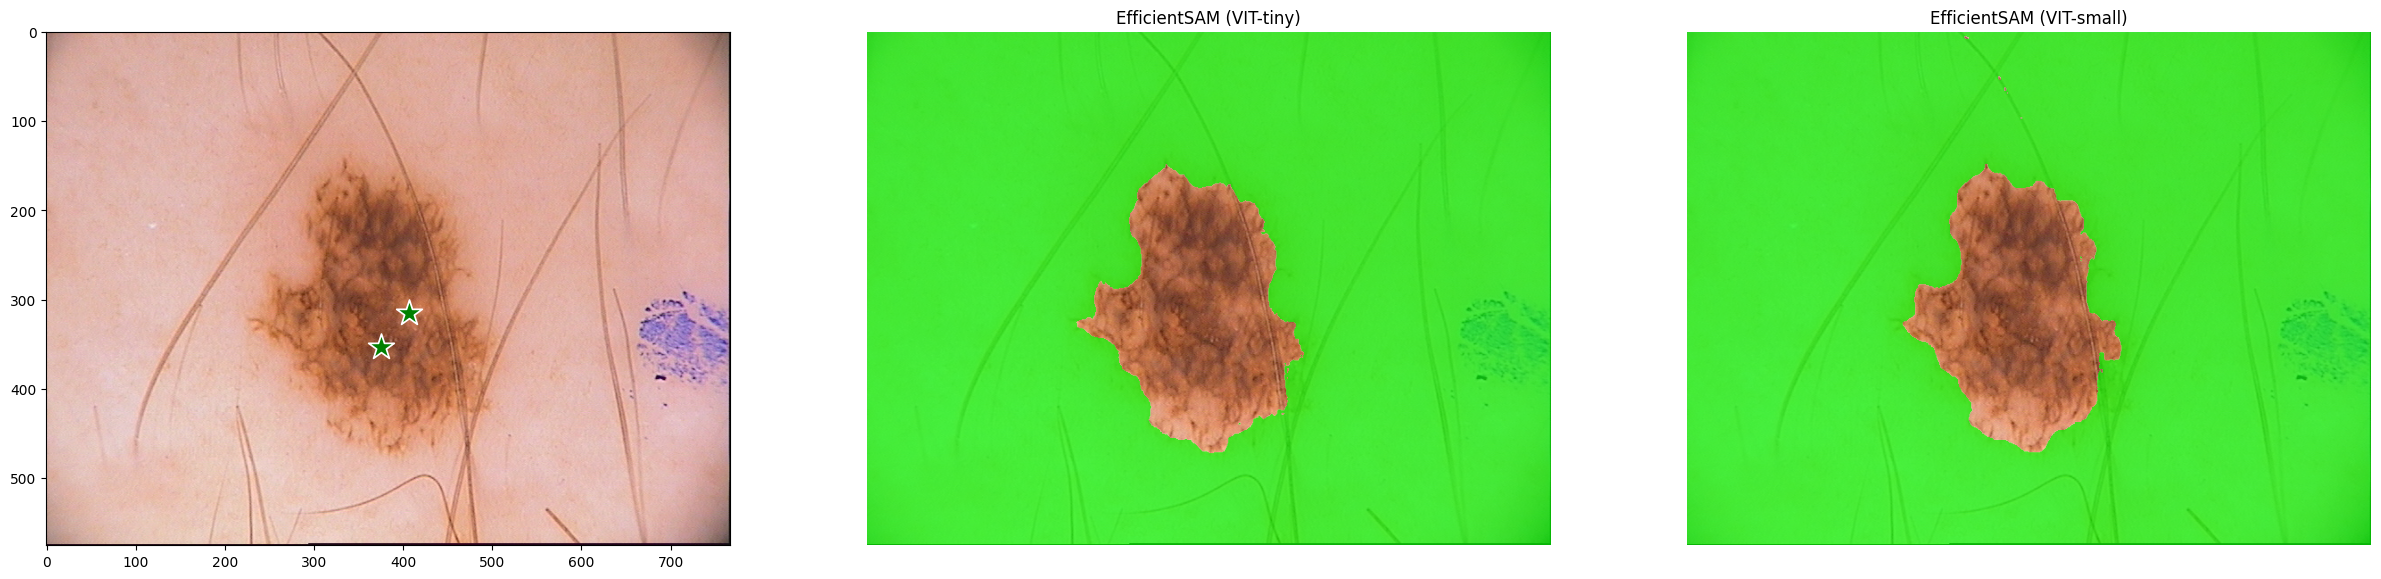

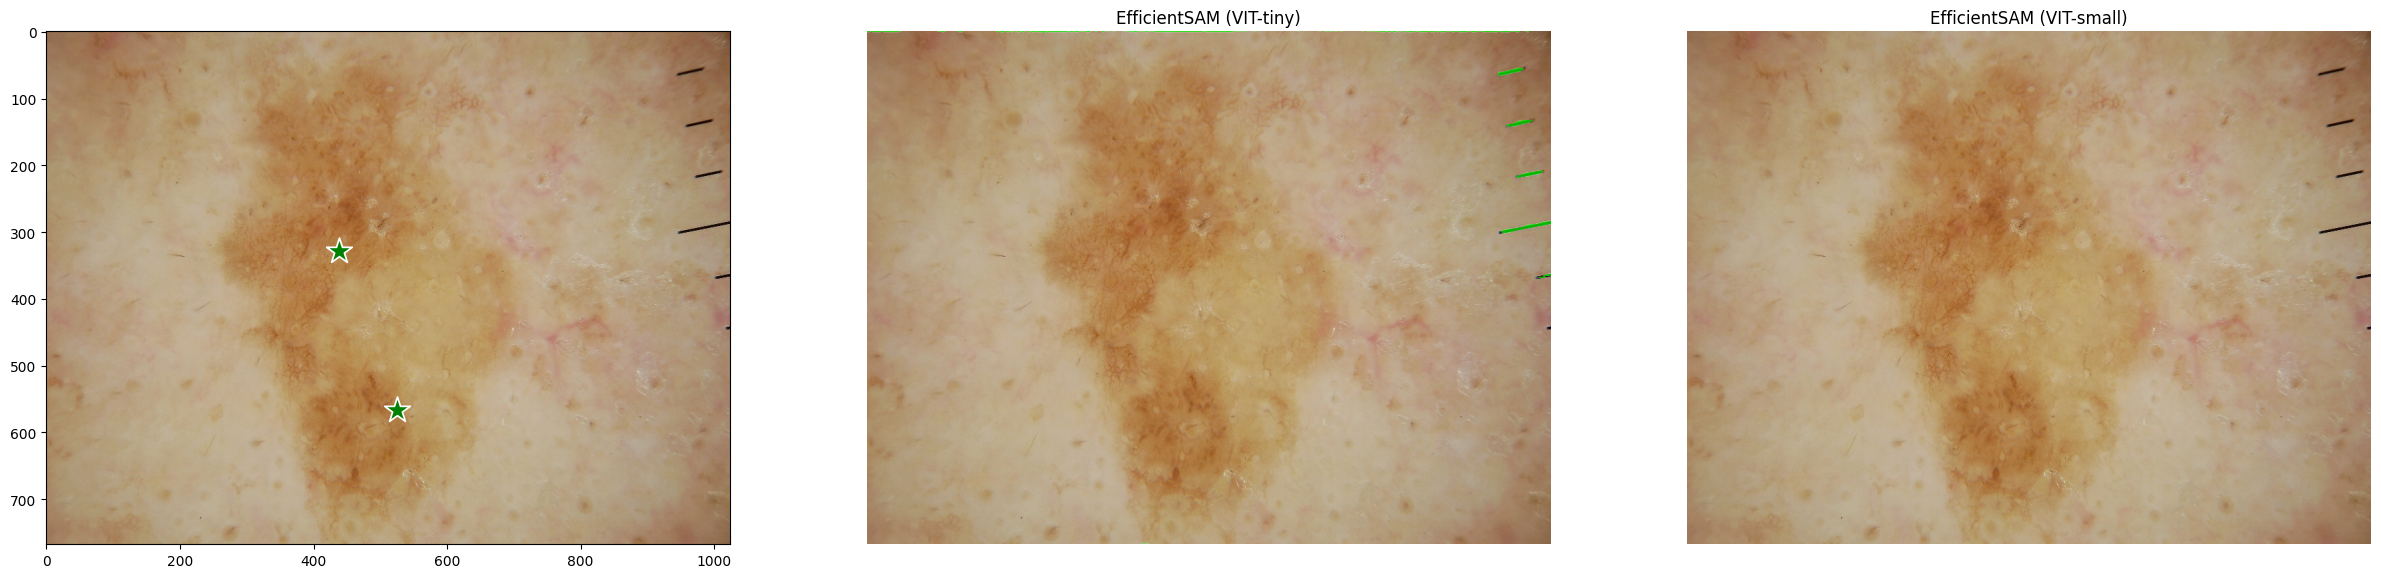

Mean Max IOU value for EfficientSAM (VIT-tiny): 0.8470372915267944
Mean Max IOU value for EfficientSAM (VIT-small): 0.9528298139572143


In [23]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

# Define the folder paths
folder_path_green = '/content/drive/MyDrive/prompting results/Skin/st3/points/'
folder_path_output_images = '/content/drive/MyDrive/imagesa21/Skin'

# Filter green files and select the first 10 in sequential order
green_files = [f"{i}_green.npy" for i in range(5)]

# Lists to store max_iou values for each model separately
max_iou_list_vitt = []
max_iou_list_vits = []

# Define the provided code for processing input_point and displaying the results
def process_and_display_input(image_path, input_point):
    fig, ax = plt.subplots(1, 3, figsize=(30, 30))

    input_label = np.array([1, 1])
    image = np.array(Image.open(image_path))
    show_points(input_point, input_label, ax[0])
    ax[0].imshow(image)

    ax[1].imshow(image)
    mask_efficient_sam_vitt, max_iou_vitt = run_ours_box_or_points(image_path, input_point, input_label, efficient_sam_vitt_model)
    show_anns_ours(mask_efficient_sam_vitt, ax[1])
    ax[1].title.set_text("EfficientSAM (VIT-tiny)")
    ax[1].axis('off')
    max_iou_list_vitt.append(max_iou_vitt)

    ax[2].imshow(image)
    mask_efficient_sam_vits, max_iou_vits = run_ours_box_or_points(image_path, input_point, input_label, efficient_sam_vits_model)
    show_anns_ours(mask_efficient_sam_vits, ax[2])
    ax[2].title.set_text("EfficientSAM (VIT-small)")
    ax[2].axis('off')
    max_iou_list_vits.append(max_iou_vits)

    plt.show()

# Load data from green files and process each file
for file_name in green_files:
    file_path_green = os.path.join(folder_path_green, file_name)
    data = np.load(file_path_green, allow_pickle=True)  # Set allow_pickle=True
    last_array = data[-1]  # Get the last array

    # Calculate input_point using the last array
    input_point = last_array[:2]

    # Pick the corresponding output image
    image_path = os.path.join(folder_path_output_images, f"output_image_{file_name.split('_')[0]}.png")

    # Perform the rest of the code for processing and displaying the input_point
    process_and_display_input(image_path, input_point)

# Calculate the mean of max_iou values for each model
mean_max_iou_vitt = np.mean(max_iou_list_vitt)
mean_max_iou_vits = np.mean(max_iou_list_vits)

# Print the mean max_iou values for each model
print("Mean Max IOU value for EfficientSAM (VIT-tiny):", mean_max_iou_vitt)
print("Mean Max IOU value for EfficientSAM (VIT-small):", mean_max_iou_vits)
